**Bayes-by-backprop prototype**

In this notebook, we implement a small prototype for Bayes-by-backprop introduced by Blundell et al.

In [1]:
import numpy as np
import os
import random
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset
import math
import torch.nn.functional as F

def set_seed(seed=1):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(1871)

In [2]:
# Regression data function
f = lambda x, epsilon: x + 0.3 * np.sin(2*np.pi * (x+epsilon)) + 0.3 * np.sin(4 * np.pi * (x+epsilon)) + epsilon

def generate_data(N, lower, upper, std, f=f):
    # create data
    x = np.linspace(lower, upper, N)

    y = []
    for i in range(N):
        epsilon = np.random.normal(0, std)
        y.append(f(x[i], epsilon))
    return x, y

# Generate train data
N_train = 2000
x, y = generate_data(N_train, lower=-0.25, upper=1, std=0.02)

# Generate validation data
N_val = 500
x_val, y_val = generate_data(N_val, lower=-0.25, upper=1, std=0.02)

# Generate test data
N_test = 500
x_test, y_test = generate_data(N_test, lower=-0.5, upper=1.5, std=0.02)

line = f(x_test, 0)

In [3]:
class ToyDataset(Dataset):
    """Custom toy dataset"""

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, idx):

        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

def collate_fn(batch):

    x, y = zip(*batch)

    return torch.tensor(x)[:,None], torch.tensor(y)

We use a diagonal Gaussian distribution (zero covariance) as the variational posterior. Rather than using just $\mu$ and $\sigma$ as the variational parameters, the standard deviation is parameterised as:
$$
\sigma = \log{(1 + \exp{(\rho)})}
$$
such that $\sigma$ is always non-negative. The variational parameters are then $\mathbf{\theta} = (\mu, \rho)$. 

The code blocks in the following sections are inspired by:

https://github.com/nitarshan/bayes-by-backprop/blob/master/Weight%20Uncertainty%20in%20Neural%20Networks.ipynb
https://colab.research.google.com/drive/1K1I_UNRFwPt9l6RRkp8IYg1504PR9q4L#scrollTo=ASGi2Ecx5G-F


In [4]:
class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0, 1)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        

    @property # @property so we can call self.sigma directly rather than self.sigma()
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):  
        # sample noise from normal distribution 
        epsilon = self.normal.sample(self.rho.size())
        epsilon = epsilon.to(self.device)
  
        return self.mu + self.sigma * epsilon # scale with mu and sigma
    
    def log_prob(self, w):
        # log pdf for Gaussian distribution
        return torch.sum(-torch.log(self.sigma) - 0.5*np.log(2*np.pi) - 0.5 * ((w - self.mu) / self.sigma)**2)

In [5]:
gauss = Gaussian(torch.tensor([1.0]), torch.tensor([30.0]))

gauss.log_prob(torch.tensor([1,2,3]))

tensor(-12.9632)

In [6]:
sigma = torch.log1p(torch.exp(torch.tensor(30.0)))
input = torch.tensor([1,2,3])
mu = torch.tensor([1.0])


(-math.log(math.sqrt(2 * math.pi))
                - torch.log(sigma)
                - ((input - mu) ** 2) / (2 * sigma ** 2)).sum()

tensor(-12.9632)

The ``Gaussian`` class is a simple class that allows us to sample from a Gaussian distribution, representing the variational posterior.

The function ``sigma`` computes the standard deviation $\sigma$ for a given $\rho$ value.
The function ``sample`` allows us to sample from the approximate posterior, using the reparametrisation trick with $\mu$ and $\sigma$. 
The function ``log_prob`` computes the log-probability density function for a normal distribution wtih mean $\mu$ and standard devation $\sigma$ (derivation below):

The probability density function for the weights $\mathbf{w}$ given the variational parameters $\mathbf{\theta} = (\mu, \rho)$ of a Gaussian distribution is given as
\begin{align*}
q(\mathbf{w|\mathbf{\theta}}) &= \prod_j \mathcal{N}(w_j | \mu, \sigma) \\
& = \prod_j \frac{1}{\sigma \sqrt{(2\pi)}} \exp{-\frac{1}{2} \left( \frac{w_j - \mu}{\sigma}    \right)^2}
\end{align*}
Then taking the log, we get:
\begin{align*}
\log{q(\mathbf{w}|\mathbf{\theta})} &=  \log{  \left( \prod_j \frac{1}{\sigma \sqrt{(2\pi)}} \exp{-\frac{1}{2} \left( \frac{w_j - \mu}{\sigma}    \right)^2} \right)} \\
           &= \sum_j \log{(1)} - \log{\left(\sigma \sqrt(2 \pi)\right) - \frac12 \left( \frac{w_j - \mu}{\sigma} \right)^2 } \\
           &= \sum_j -\log{(\sigma)} - \frac12 \log{(2\pi)} - \frac12 \left( \frac{w_j - \mu}{\sigma} \right)^2
\end{align*}

The prior that was proposed in the paper by Blundell et al. is a Gaussian mixture prior over the weights $\mathbf{w}$. 
$$
P(\mathbf{w}) = \prod_j \pi \mathcal{N}(w_j|0, \sigma_1^2) + (1-\pi) \mathcal{N}(w_j| 0, \sigma_2^2) 
$$
where $\pi \in [0,1]$ is the mixture weight.

In [7]:
class ScaleMixturePrior(object):
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()

        """
        Implementing the scale mixture prior in equation 7 of the paper.
        From the paper: sigma1 > sigma2 and sigma2 << 1.
        """
        assert sigma1 > sigma2, "Error: sigma1 must be greater than sigma2."
        assert sigma2 < 1, "Error: sigma2 must be less than 1."

        self.pi = pi
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.sigma1 = sigma1
        self.sigma2 = sigma2

        self.gaussian1 = torch.distributions.Normal(torch.tensor(0).to(self.device),sigma1.to(self.device))
        self.gaussian2 = torch.distributions.Normal(torch.tensor(0).to(self.device),sigma2.to(self.device))
       

    def log_prob(self, w):
        """
        Implementing the log pdf for the scale mixture prior
        """

        p1 = torch.exp(self.gaussian1.log_prob(w)) # torch.exp of log pdf so we get the pdf
        p2 = torch.exp(self.gaussian2.log_prob(w))
        return torch.log(self.pi * p1 + (1-self.pi) * p2).sum()

    

In [8]:
mixture = ScaleMixturePrior(pi=torch.tensor(0.5), sigma1=torch.exp(torch.tensor(0)), sigma2=torch.exp(torch.tensor(-6)))

mixture.log_prob(torch.tensor([1,2,3]).to('cuda'))

tensor(-11.8363, device='cuda:0')

We implement a Bayesian linear layer for our Bayesian neural network. 

In [9]:
# seed workers for reproducibility
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

traindata = ToyDataset(x, y)
trainloader = DataLoader(traindata, batch_size=512, shuffle=True, worker_init_fn=seed_worker, generator=g, collate_fn=collate_fn)

valdata = ToyDataset(x_val, y_val)
valloader = DataLoader(valdata, batch_size=60, shuffle=False, collate_fn=collate_fn)

testdata = ToyDataset(x_test, y_test)
testloader = DataLoader(testdata, batch_size=N_test, shuffle=False, collate_fn=collate_fn)

NUM_BATCHES = len(trainloader)

In [10]:
# class BayesianLinearLayer(nn.Module):
#     def __init__(self, input_dim, output_dim, pi=0.5, sigma1=torch.exp(torch.tensor([-0])), sigma2=torch.exp(torch.tensor([-6]))):
#         super().__init__()
#         self.input_dim = input_dim
#         self.output_dim = output_dim
#         self.pi = pi
#         self.sigma1 = sigma1
#         self.sigma2 = sigma2

#         # initialise mu and rho parameters so they get updated in backpropagation
#         self.weight_mus = nn.Parameter(torch.Tensor(input_dim, output_dim).uniform_(-0.05, 0.05))
#         self.weight_rhos = nn.Parameter(torch.Tensor(input_dim, output_dim).uniform_(-2, -1)) 
#         self.bias_mus = nn.Parameter(torch.Tensor(output_dim).uniform_(-0.05, 0.05))
#         self.bias_rhos = nn.Parameter(torch.Tensor(output_dim).uniform_(-2, -1))

#         # create approximate posterior distribution
#         self.weight_posterior = Gaussian(self.weight_mus, self.weight_rhos)
#         self.bias_posterior = Gaussian(self.bias_mus, self.bias_rhos)

#         # scale mixture posterior
#         self.weight_prior = ScaleMixturePrior(pi=pi, sigma1=sigma1, sigma2=sigma2)
#         self.bias_prior = ScaleMixturePrior(pi=pi, sigma1=sigma1, sigma2=sigma2)

#         self.log_prior = 0.0
#         self.log_variational_posterior = 0.0

#         self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     def forward(self, x, inference=False):
#         if inference:
#             w = self.weight_mus
#             b = self.bias_mus
#             output = torch.mm(x, w) + b

#             self.log_prior = 0
#             self.log_variational_posterior = 0

            
#         else:
#             # sample from approximate posterior distribution
#             w = self.weight_posterior.sample()
#             b = self.bias_posterior.sample()

#             # compute log prior and log variational posterior
#             self.log_prior = self.weight_prior.log_prob(w) + self.bias_prior.log_prob(b)
#             self.log_variational_posterior = self.weight_posterior.log_prob(w) + self.bias_posterior.log_prob(b)

#         output = torch.mm(x, w) + b

#         return output


In [23]:
# class BayesianNeuralNetwork(nn.Module):
#     def __init__(self, hidden_units1, hidden_units2, pi=0.5, sigma1=torch.exp(torch.tensor([-0])), sigma2=torch.exp(torch.tensor([-6])), device="cpu"):
#         super().__init__()
#         self.hidden_units1 = hidden_units1
#         self.hidden_units2 = hidden_units2
#         self.pi = pi
#         self.sigma1 = sigma1
#         self.sigma2 = sigma2

#         self.l1 = BayesianLinearLayer(1, hidden_units1)
#         self.l2 = BayesianLinearLayer(hidden_units1, hidden_units2)
#         self.l3 = BayesianLinearLayer(hidden_units2, 2)

#         self.layers = [self.l1, self.l2, self.l3]
        
#         self.device = device

#     def forward(self, x, inference=False):
#         x = x.to(self.device)
#         x = F.relu(self.l1(x.to(self.device), inference))
#         x = F.relu(self.l2(x.to(self.device), inference))
#         x = self.l3(x.to(self.device), inference)

#         return x

#     def compute_log_prior(self):
#         log_prior = 0
#         for layer in self.layers:
#            log_prior += layer.log_prior
#         return log_prior
    
#     def compute_log_variational_posterior(self):
#         log_variational_posterior = 0
#         for layer in self.layers:
#             log_variational_posterior += layer.log_variational_posterior
#         return log_variational_posterior
    
#     def get_sigma(self, rho):
#         return torch.log1p(torch.exp(rho))
    
#     def log_gaussian_loss(self, target, mu, sigma):
#         target = target.to(self.device)
#         mu = mu.to(self.device)
#         sigma = sigma.to(self.device)
#         return (-0.5 * torch.log(torch.tensor(2 * np.pi)) - torch.log(sigma)) - (target - mu)**2 / (2 * sigma**2).mean().float()
    
#     def compute_ELBO(self, input, target, n_samples=10):
#         outputs = torch.zeros(n_samples, target.size(0)).to(self.device)
#         log_priors = torch.zeros(n_samples).to(self.device)
#         log_variational_posteriors = torch.zeros(n_samples).to(self.device)
#         NLLs = torch.zeros(n_samples).to(self.device)
#         for i in range(n_samples):
#             outputs = self.forward(input, inference=False)
#             mu = outputs[:,0]
#             sigma = self.get_sigma(outputs[:,1])
#             # print(sigma)
#             log_priors[i] = self.compute_log_prior()
#             log_variational_posteriors[i] = self.compute_log_variational_posterior()
#             NLLs[i] = -self.log_gaussian_loss(target, mu, sigma).sum()
#         log_prior = log_priors.mean(0)
#         log_variational_posterior = log_variational_posteriors.mean(0)
#         NLL = NLLs.mean(0)

#         loss = log_variational_posterior - log_prior + NLL
#         return loss, log_prior, log_variational_posterior, NLL
    


In [24]:
class BayesianLinearLayer(nn.Module):
    def __init__(self, input_dim, output_dim, pi=0.5, sigma1=torch.exp(torch.tensor([-0])), sigma2=torch.exp(torch.tensor([-6]))):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2

        # initialise mu and rho parameters so they get updated in backpropagation
        self.weight_mus = nn.Parameter(torch.Tensor(input_dim, output_dim).uniform_(-0.05, 0.05))
        self.weight_rhos = nn.Parameter(torch.Tensor(input_dim, output_dim).uniform_(-2, -1)) 
        self.bias_mus = nn.Parameter(torch.Tensor(output_dim).uniform_(-0.05, 0.05))
        self.bias_rhos = nn.Parameter(torch.Tensor(output_dim).uniform_(-2, -1))

        # create approximate posterior distribution
        self.weight_posterior = Gaussian(self.weight_mus, self.weight_rhos)
        self.bias_posterior = Gaussian(self.bias_mus, self.bias_rhos)

        # scale mixture posterior
        self.weight_prior = ScaleMixturePrior(pi=pi, sigma1=sigma1, sigma2=sigma2)
        self.bias_prior = ScaleMixturePrior(pi=pi, sigma1=sigma1, sigma2=sigma2)

        self.log_prior = 0.0
        self.log_variational_posterior = 0.0

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, x, inference=False):
        if inference:
            # during inference, we simply use the mus of the weights and biases
            w = self.weight_mus
            b = self.bias_mus

            self.log_prior = 0.0
            self.log_variational_posterior = 0.0
        else:
            # sample from approximate posterior distribution
            w = self.weight_posterior.sample()
            b = self.bias_posterior.sample()

            # compute log prior and log variational posterior
            self.log_prior = self.weight_prior.log_prob(w) + self.bias_prior.log_prob(b)
            self.log_variational_posterior = self.weight_posterior.log_prob(w) + self.bias_posterior.log_prob(b)
            # print("log_prior:", self.log_prior)
        
        x = x.to(self.device)
        return torch.mm(x, w) + b # matrix multiply input by weights and add bias


class BayesianNeuralNetwork(nn.Module):

    def __init__(self, hidden_units1, hidden_units2, pi=0.5, sigma1=torch.exp(torch.tensor([-0])), sigma2=torch.exp(torch.tensor([-6])), device='cpu'):
        super().__init__()
        self.l1 = BayesianLinearLayer(1, hidden_units1)
        self.l2 = BayesianLinearLayer(hidden_units1, hidden_units2)
        self.l3 = BayesianLinearLayer(hidden_units2, 2) # output channel = 2 for mean and variance

        self.model = [self.l1, self.l2, self.l3]
        
        self.device = device

    def forward(self, x, inference=False):
        x = x.to(self.device)
        x = F.relu(self.l1(x.to(self.device), inference))
        x = F.relu(self.l2(x.to(self.device), inference))
        x = self.l3(x.to(self.device), inference)

        return x
    
    def compute_log_prior(self):
        # return self.model[0].log_prior + self.model[2].log_prior + self.model[4].log_prior
        model_log_prior = 0.0
        for layer in self.model:
            if isinstance(layer, BayesianLinearLayer):
                # print(layer.log_prior.shape)
                model_log_prior += layer.log_prior

        return model_log_prior

    def compute_log_variational_posterior(self):
        # return self.model[0].log_variational_posterior + self.model[2].log_variational_posterior + self.model[4].log_variational_posterior
        model_log_variational_posterior = 0.0
        for layer in self.model:
            if isinstance(layer, BayesianLinearLayer):
                # print(layer.log_variational_posterior)
                model_log_variational_posterior += layer.log_variational_posterior

        return model_log_variational_posterior

    def get_sigma(self, rho):
        return torch.log1p(torch.exp(rho))


    def compute_ELBO(self, input, target, n_samples=10):
        # formula from Blundell: loss = log_variational_posterior - log_prior - log_likelihood
        #                        loss = log_variational_posterior - log_prior + NLL
        
        # compute log prior and log variational posterio

        mus  = torch.zeros(n_samples, input.shape[0])
        rhos = torch.zeros(n_samples, input.shape[0])       
        log_priors = torch.zeros(n_samples)
        log_variational_posteriors = torch.zeros(n_samples)

        for i in range(n_samples):
            output = self.forward(input, inference=False).to(self.device)
            mu = output[:,0]
            rho = output[:,1]

            log_priors[i] = self.compute_log_prior()
            log_variational_posteriors[i] = self.compute_log_variational_posterior()
            mus[i] = mu
            rhos[i] = rho


        # self.NLL = self.NLL_loss(target, mus, rhos)
        # print("target", target.shape)
        # print("mus", mus.shape)
        # print("sigmas", self.get_sigma(rhos).shape)

        

        self.NLL = torch.nn.GaussianNLLLoss(reduction='mean')(target, mus.mean(0).to(self.device), self.get_sigma(rhos).mean(0).to(self.device))

        loss = (log_variational_posteriors.mean() - log_priors.mean()) / NUM_BATCHES + self.NLL

        # print(log_priors.mean(), log_variational_posteriors.mean(), self.NLL, loss)

        return loss, log_priors.mean(), log_variational_posteriors.mean(), self.NLL

    def NLL_loss(self, target, mu, rho):
        # negative log likelihood loss

        sigma = self.get_sigma(rho)
        
        # take mean over samples
        mu = mu.mean(dim=0)
        sigma = sigma.mean(dim=0)

        mu = mu.to(self.device)
        sigma = sigma.to(self.device)

        # mean reduction 
        # print((1 / (2 * sigma.pow(2)) * (target - mu).pow(2) + torch.log(sigma)).mean())
        norm = torch.distributions.Normal(mu, sigma)
        # print(norm.log_prob(target).mean())

        # return (1 / (2 * sigma.pow(2)) * (target - mu).pow(2) + torch.log(sigma)).mean()
        return -norm.log_prob(target).mean()
    


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create model
BNN_model = BayesianNeuralNetwork(32, 128, device=device)
BNN_model.to(device)
optimizer = torch.optim.SGD(BNN_model.parameters(), lr=3e-4)



In [26]:
target = torch.tensor([1.0]).to(device)
mu = torch.tensor([1.0]).to(device)
rho = torch.tensor([-6.1]).to(device)

BNN_model.NLL_loss(target, mu, rho)

tensor(-5.1822, device='cuda:0')

In [27]:
for x_test, y_test in testloader:
    x_test = x_test.float().to(device)
    y_test = y_test.float().to(device)

    loss, log_prior, log_variational_posterior, NLL = BNN_model.compute_ELBO(x_test, y_test, n_samples=10)
    print("ELBO:", loss)
    print("log_prior:", log_prior)
    print("log_variational_posterior:", log_variational_posterior)
    print("NLL:", NLL)
    break

ELBO: tensor(1902.5393, device='cuda:0', grad_fn=<AddBackward0>)
log_prior: tensor(-6774.4580, grad_fn=<MeanBackward0>)
log_variational_posterior: tensor(832.7912, grad_fn=<MeanBackward0>)
NLL: tensor(0.7271, device='cuda:0', grad_fn=<MeanBackward0>)


In [28]:
for x_test, y_test in testloader:
    x_test = x_test.float().to(device)
    y_test = y_test.float().to(device)

    output = BNN_model(x_test, inference=True)
    print(output.shape)
    break

torch.Size([500, 2])


In [29]:
mu = output[:,0]
print(mu.shape)

torch.Size([500])


In [30]:
# useful functions 🤖

def train_BNN(model, optimizer, trainloader, valloader, epochs=500, model_name='BNN', val_every_n_epochs=10, device='cpu'):

    losses = []
    log_priors = []
    log_variational_posteriors = []
    NLLs = []

    val_losses = []
    val_log_priors = []
    val_log_variational_posteriors = []
    val_NLLs = []

    best_val_loss = np.inf

    for e in tqdm(range(epochs)):
        
        for x_, y_ in trainloader:

            model.train()

            x_, y_ = x_.float().to(device), y_.float().to(device)

            optimizer.zero_grad()

            loss, log_prior, log_posterior, log_NLL = model.compute_ELBO(x_, y_)
            # print(loss)

            loss.backward()
            optimizer.step()

            losses.append(loss.item()) 
            log_priors.append(log_prior.item())
            log_variational_posteriors.append(log_posterior.item())
            NLLs.append(log_NLL.item()) 

        if (e+1) % val_every_n_epochs == 0:
            model.eval()

            val_loss_list = []
            with torch.no_grad():
                for val_x, val_y in valloader:
                    val_x, val_y = val_x.float().to(device), val_y.float().to(device)
                
                    val_loss, _ , _, _ = model.compute_ELBO(val_x, val_y)
                    val_loss_list.append(val_loss.item())

            val_losses.extend(val_loss_list)
            mean_val_loss = np.mean(val_loss_list)
            if mean_val_loss < best_val_loss:
                best_val_loss = mean_val_loss
                torch.save(model, f'{model_name}.pt')
            # print(f"Mean validation loss at epoch {e}: {mean_val_loss}")

    return losses, log_priors, log_variational_posteriors, NLLs, val_losses


def plot_loss(losses, val_losses):

    fig, ax = plt.subplots(1,2, figsize=(12,6))

    ax[0].plot(losses, label='Train loss')
    ax[0].set_title('Train loss')
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Loss')

    ax[1].plot(val_losses, label='Validation loss', color='orange')
    ax[1].set_title('Validation loss')
    ax[1].set_xlabel('Iterations')
    ax[1].set_ylabel('Loss')

    plt.show()


def plot_log_probs(log_priors, log_variational_posteriors, NLLs):

    fig, ax = plt.subplots(1,3, figsize=(18,6))

    ax[0].plot(log_priors, label='Train log prior')
    ax[0].set_title('Train log prior')
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Log prior')

    ax[1].plot(log_variational_posteriors, label='Train log variational posterior', color='orange')
    ax[1].set_title('Train log variational posterior')
    ax[1].set_xlabel('Iterations')
    ax[1].set_ylabel('Log variational posterior')

    ax[2].plot(NLLs, label='Train NLL', color='green')
    ax[2].set_title('Train NLL')
    ax[2].set_xlabel('Iterations')
    ax[2].set_ylabel('NLL')

    plt.show()

In [31]:
losses, log_priors, log_variational_posteriors, NLLs, val_losses = train_BNN(BNN_model, optimizer, trainloader, valloader, epochs=2500, model_name='BNN', val_every_n_epochs=10, device=device)

plot_loss(losses, val_losses)

  0%|          | 0/2500 [00:00<?, ?it/s]

: 

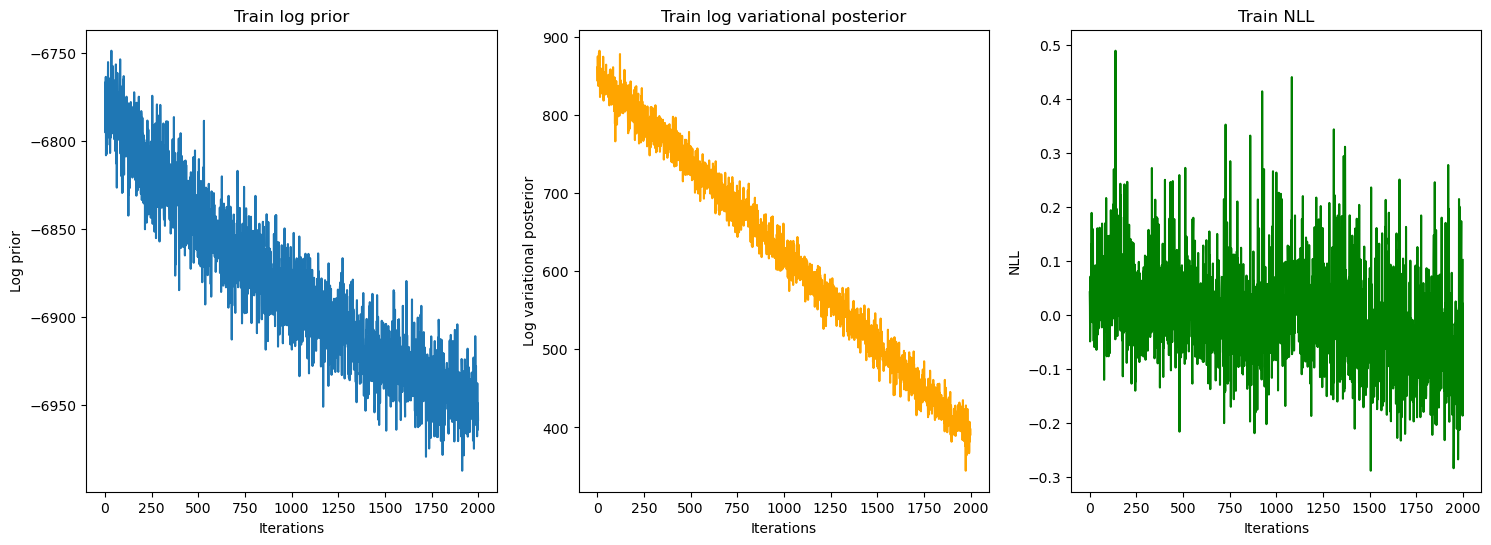

In [ ]:
plot_log_probs(log_priors, log_variational_posteriors, NLLs)

# Inference

We perform inference with the BNN model.

In [ ]:
model = torch.load("BNN.pt")

predictions = []
stdds = []

for x_test, y_test in testloader:
    x_test, y_test = x_test.float(), y_test.float()
    with torch.no_grad():
        output = model(x_test, test=False)
        mu = output[:,0]
        rho = output[:,1]
        sigma = model.get_sigma(rho)
        predictions.append(mu.cpu().detach().numpy())
        stdds.append(sigma.cpu().detach().numpy())
        




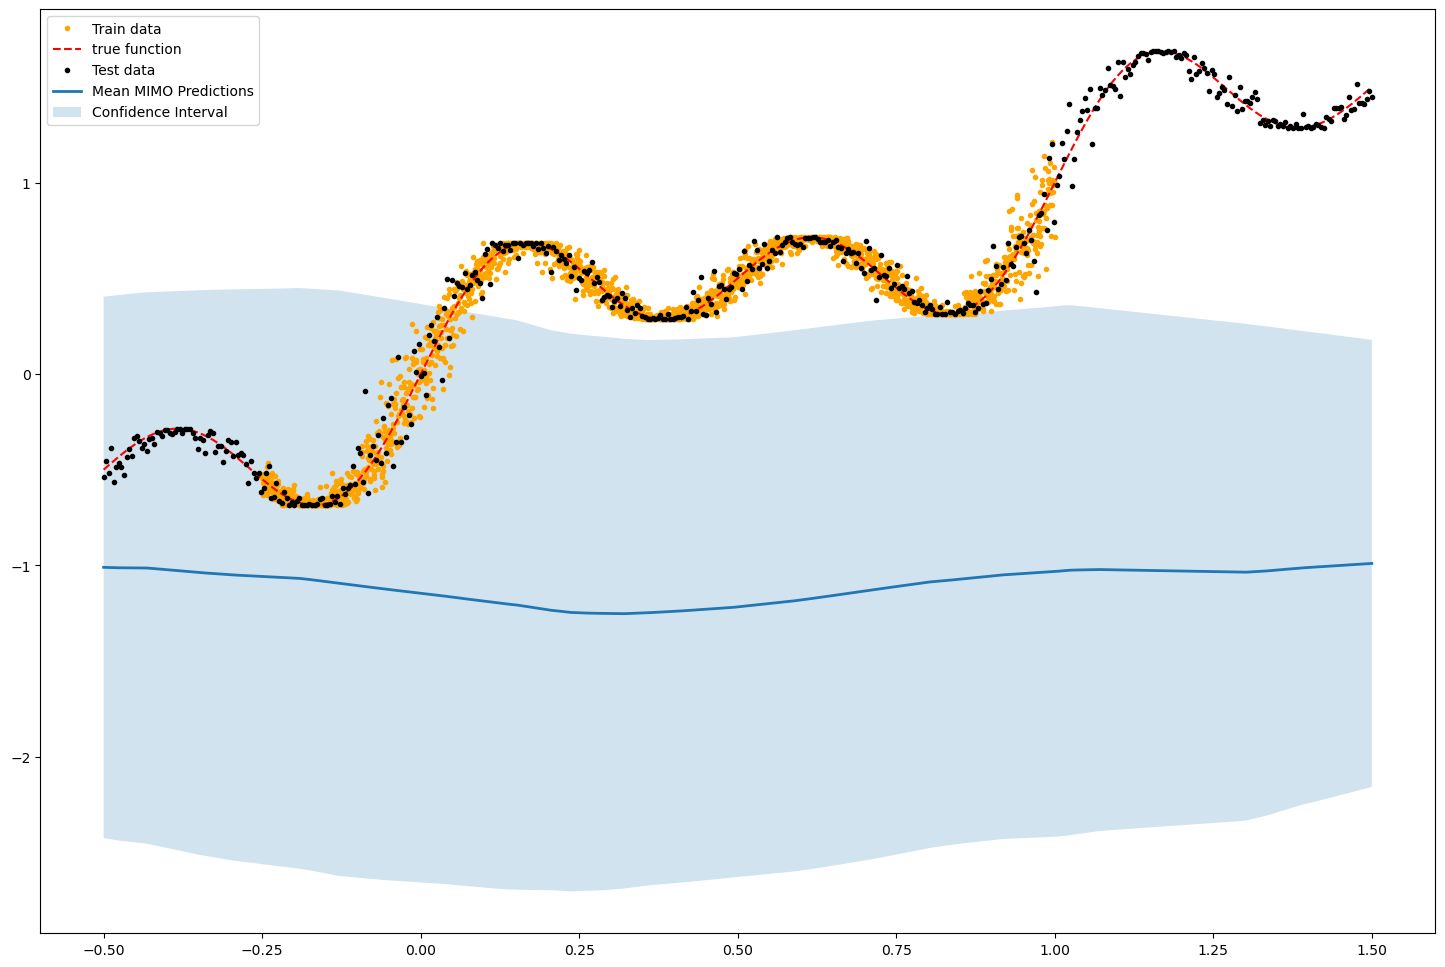

In [ ]:
# plot data
fig, ax = plt.subplots(1,1, figsize=(18,12))

### plot mimo ###
plt.plot(x, y, '.', label='Train data', color='orange')
plt.plot(x_test[:,0], line, '--', label='true function', color='red')
# plot test data
plt.plot(x_test[:,0], y_test, '.', label='Test data', color='black')

# plot predicitons with confidence intervals
plt.plot(x_test[:,0], predictions[0], '-', label=f'Mean MIMO Predictions', linewidth=2)
plt.fill_between(x_test[:,0], predictions[0] - 1.96*stdds[0], predictions[0] + 1.96*stdds[0], alpha=0.2, label=f'Confidence Interval')

plt.legend()

plt.show()
